In [1]:
import numpy as np 
import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy as np
from skimage import data, img_as_float
import math 
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

pi = math.pi


In [2]:
def texture_hist(img, directions = [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/2]):
    res = []
    
    for image_ch in (0,1,2):
        im = img[:,:,image_ch]
        for d in directions:
            hor = gaussian_filter(im,(1,0))
            ver = gaussian_filter(im,(0,1))
            hist, _ = np.histogram(hor*math.cos(d) + ver*math.sin(d),10)
            res = res + list(hist)
    res = np.array(res)
    res = res/np.sum(res)
    return res
            
    
    
    
    
    
    
    

In [3]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


# SELECTIVE SEARCH ALGORITHM 

## CREATE FIRST SEGMENTS

First of all, we get an initial set of small regions by applying the 13 algorithm--> very fast and usefull

In [4]:
def generate_segments(im_orig, scale, sigma, min_size):
    image = skimage.util.img_as_float(im_orig)
    im_mask = skimage.segmentation.felzenszwalb(image, scale=scale, sigma=sigma,min_size=min_size)
    #add the mask as fourth dimension image
    im_orig = np.append(im_orig, np.zeros(im_orig.shape[:2])[:, :, np.newaxis], axis=2)
    im_orig[:, :, 3] = im_mask
    return im_orig

## CALCULATE THE SIMILARITY MEASURE

Choose 4 similarity measure to compare differen zone 

In [5]:
def sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize


def calc_sim(r1, r2, imsize):
    return (sim_colour(r1, r2) + sim_texture(r1, r2)
            + sim_size(r1, r2, imsize) + sim_fill(r1, r2, imsize))


## CALCULATION OF HISTOGRAMS 



In [6]:
def calc_colour_hist(img):
    """
        calculate colour histogram for each region
        the size of output histogram will be BINS * COLOUR_CHANNELS(3)
        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]
        extract HSV
    """

    BINS = 25
    hist = np.array([])

    for colour_channel in (0, 1, 2):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(c, BINS, (0.0, 255.0))[0]])

    # L1 normalize
    hist = hist / len(img)

    return hist


def calc_texture_gradient(img):
    """
        calculate texture gradient for entire image
        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.
        output will be [height(*)][width(*)]
    """
    ret = np.zeros((img.shape[0], img.shape[1], img.shape[2]))

    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret


def calc_texture_hist(img):
    """
        calculate texture histogram for each region
        calculate the histogram of gradient for each colours
        the size of output histogram will be
            BINS * ORIENTATIONS * COLOUR_CHANNELS(3)
    """
    BINS = 10

    hist = np.array([])

    for colour_channel in (0, 1, 2):

        # mask by the colour channel
        fd = img[:, colour_channel]

        # calculate histogram for each orientation and concatenate them all
        # and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(fd, BINS, (0.0, 1.0))[0]])

    # L1 Normalize
    hist = hist / len(img)

    return hist

In [7]:

def extract_regions(img,guassian_filter):

    R = {}

    # get hsv image
    hsv = skimage.color.rgb2hsv(img[:, :, :3])
    print("hsv")
    # pass 1: count pixel positions
    for y, i in enumerate(img):

        for x, (r, g, b, l) in enumerate(i):

            # initialize a new region
            if l not in R:
                R[l] = {
                    "min_x": 0xffff, "min_y": 0xffff,
                    "max_x": 0, "max_y": 0, "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y

    # pass 2: calculate texture gradient
    print("gradient")
    tex_grad = calc_texture_gradient(img)

    # pass 3: calculate colour histogram of each region
    for k, v in list(R.items()):

        # colour histogram
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        R[k]["size"] = len(masked_pixels / 4)
        R[k]["hist_c"] = calc_colour_hist(masked_pixels)

        # texture histogram
        if(gaussian_filter == True):
            R[k]["hist_t"] = texture_hist(img[v['min_x']:v['max_x'],v['min_y']:v['max_y'],:])
        else:
            R[k]["hist_t"] = calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])
    return R


def extract_neighbours(regions):

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours


def merge_regions(r1, r2):
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (
            r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (
            r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt


In [8]:
def selective_search(im_orig, scale=1.0, sigma=0.8, min_size=50, gaussian_filter = False):
    '''Selective Search
    Parameters
    ----------
        im_orig : ndarray
            Input image
        scale : int
            Free parameter. Higher means larger clusters in felzenszwalb segmentation.
        sigma : float
            Width of Gaussian kernel for felzenszwalb segmentation.
        min_size : int
            Minimum component size for felzenszwalb segmentation.
    Returns
    -------
        img : ndarray
            image with region label
            region label is stored in the 4th value of each pixel [r,g,b,(region)]
        regions : array of dict
            [
                {
                    'rect': (left, top, width, height),
                    'labels': [...],
                    'size': component_size
                },
                ...
            ]
    '''
    assert im_orig.shape[2] == 3, "3ch image is expected"

    # load image and get smallest regions
    # region label is stored in the 4th value of each pixel [r,g,b,(region)]
    print("generatate_segments")
    img = generate_segments(im_orig, scale, sigma, min_size)
    print("end")
    if img is None:
        return None, {}

    imsize = img.shape[0] * img.shape[1]
    print("extract regions")
    R = extract_regions(img,gaussian_filter)
    print("end")

    # extract neighbouring information
    print("extract neighbours")
    neighbours = extract_neighbours(R)
    print("end")

    # calculate initial similarities
    print("sim")
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = calc_sim(ar, br, imsize)
    print("end")
    # hierarchal search
    while S != {}:
        
        # get highest similarity
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # merge corresponding regions
        t = max(R.keys()) + 1.0
        R[t] = merge_regions(R[i], R[j])

        # mark similarities for regions to be removed
        key_to_delete = []
        for k, v in list(S.items()):
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # remove old similarities of related regions
        for k in key_to_delete:
            del S[k]

        # calculate similarity set with the new region
        for k in [a for a in key_to_delete if a != (i, j)]:
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = calc_sim(R[t], R[n], imsize)

    regions = []
    for k, r in list(R.items()):
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'], r['max_y']),
            'size': r['size'],
            'labels': r['labels']
        })

    return img, regions

In [9]:
import cv2
import os
lista_immagini = os.listdir("selective_search_images")

In [12]:
lista_immagini = ["selective_search_images/" + i for i in lista_immagini] 

In [45]:
res = []
for i,im in enumerate(lista_immagini):
    print(im)
    img = cv2.imread(im)
    img = cv2.resize(img, (512,512))
    img_lbl, regions = selective_search(img, scale=250, sigma=0.8, min_size=8,gaussian_filter=False)
    reg = sorted(regions, key=lambda k: k['size'])
    res.append(reg)
    
    

selective_search_images/prova1.jpg
generatate_segments
end
extract regions
hsv
gradient
end
extract neighbours
end
sim
end
selective_search_images/prova3.jpg
generatate_segments
end
extract regions
hsv
gradient
end
extract neighbours
end
sim
end
selective_search_images/prova2.jpg
generatate_segments
end
extract regions
hsv
gradient
end
extract neighbours
end
sim
end
selective_search_images/prova4.jpg
generatate_segments
end
extract regions
hsv
gradient
end
extract neighbours
end
sim
end


In [46]:
len(res[1])

1725

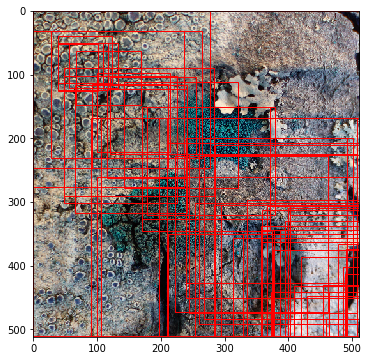

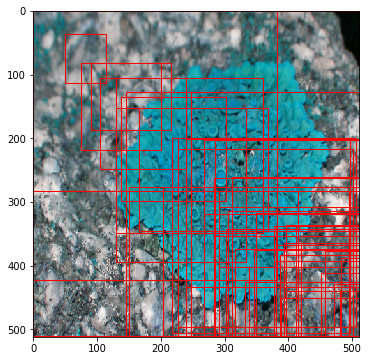

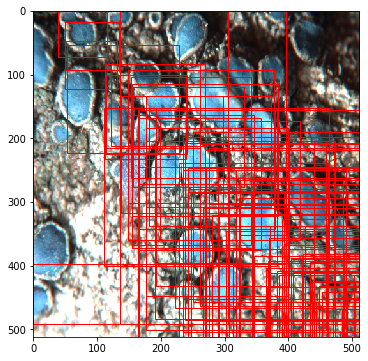

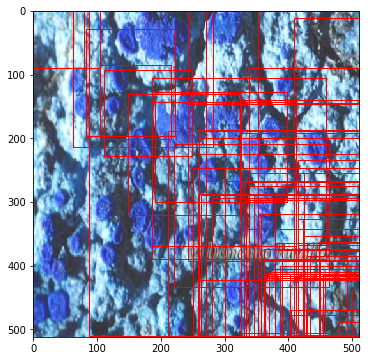

In [51]:
import matplotlib.patches as mpatches

for ii,results in enumerate(res):
    candidates = set()
    for r in results:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 100:
            continue
        #print("computing iou")
        iou_vector = []
        for c in candidates:
            iou_vector.append(bb_intersection_over_union(r['rect'], c))
        if(len(candidates) > 0 and np.max(iou_vector)>0.80):
            #print("scarto")
            continue



        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r['rect'])
    img = cv2.imread(lista_immagini[ii])
    img = cv2.resize(img, (512,512))
    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    for x, y, w, h in candidates:

        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)


    plt.savefig("selectivesearch_res/" + "ROI_" + lista_immagini[ii].split("/")[1])

    plt.show()

In [42]:
import import_ipynb
import Segmenter

In [152]:
s = Segmenter.Segmenter("../prova2.jpg")

In [156]:
ls = s.chan_vese(save = False)